## 1.Importing necessary libraries 
 

In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## 2.Reading data from a CSV file


In [578]:
file_path = 'Data/Swaziland.csv'
df = pd.read_csv(file_path)
df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN
0,ZI000067975,"MASVINGO, ZI",-20.067,30.867,1095.0,1974-01,73.0,82.5,63.5
1,ZI000067975,"MASVINGO, ZI",-20.067,30.867,1095.0,1974-02,71.2,78.9,63.5
2,ZI000067975,"MASVINGO, ZI",-20.067,30.867,1095.0,1974-03,69.5,78.0,60.9
3,ZI000067975,"MASVINGO, ZI",-20.067,30.867,1095.0,1974-04,62.8,72.4,53.3
4,ZI000067975,"MASVINGO, ZI",-20.067,30.867,1095.0,1974-05,59.6,72.6,46.7
...,...,...,...,...,...,...,...,...,...
687,ZI000067775,"HARARE KUTSAGA, ZI",-17.917,31.133,1480.0,2016-02,NaN,NaN,61.8
688,ZI000067775,"HARARE KUTSAGA, ZI",-17.917,31.133,1480.0,2016-03,NaN,82.2,NaN
689,ZI000067775,"HARARE KUTSAGA, ZI",-17.917,31.133,1480.0,2017-05,NaN,75.2,NaN
690,ZI000067775,"HARARE KUTSAGA, ZI",-17.917,31.133,1480.0,2017-08,NaN,NaN,45.8


## For start date, end date, to help with number of rows to look for in functions

In [595]:
df['DATE'] = pd.to_datetime(df['DATE'])
min_date = df['DATE'].min()
max_date = df['DATE'].max()
diff_months = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month

print("Minimum date:", min_date)
print("Maximum date:", max_date)
print("Difference in months:", diff_months+1)

Minimum date: 1974-01-01 00:00:00
Maximum date: 2024-01-01 00:00:00
Difference in months: 601


#
## 3.Function to identify missing rows for each city in the dataset
- ### Function 'multiple_cities' identifies missing rows for each city in the dataset.
- ### Missing rows are determined where 'TAVG' (average temperature) is NaN.
- ### Results are printed showing the number of missing rows for each city.

### Note: Run this to know the number of missing dates from 1974 to 2023 end. Change dates based on above output
#

In [596]:
def multiple_cities(df):
    if 'STATION' in df.columns:
        date_range = pd.date_range(start=min_date, end=max_date, freq='MS')
        all_dates = pd.DataFrame(date_range, columns=['DATE'])
        grouped_df = df.groupby('STATION')
        missing_rows_per_city = {}
        for city, city_data in grouped_df: 
            merged_df = pd.merge(all_dates, city_data, on='DATE', how='left')
            missing_rows_avg = merged_df[merged_df['TAVG'].isna()]
            missing_rows_max = merged_df[merged_df['TMAX'].isna()]
            missing_rows_min = merged_df[merged_df['TMIN'].isna()]
            missing_rows_per_city[city] = [len(missing_rows_avg),len(missing_rows_max),len(missing_rows_min)]
        for city, missing_rows in missing_rows_per_city.items():
            print("Missing rows for", city)
            print(missing_rows)
            print("\n")
        filled_df = pd.DataFrame(columns=df.columns)
        for city in df['STATION'].unique():
            city_data = df[df['STATION'] == city]
            merged_data = pd.merge(all_dates, city_data, on='DATE', how='left')
            merged_data['STATION']=city
            merged_data['NAME']=merged_data['NAME'].value_counts().keys()[0]
            filled_df = filled_df.append(merged_data, ignore_index=True)
        return filled_df
    else:
        return df
    
df = multiple_cities(df)

KeyError: 'TMAX'

In [581]:
if 'STATION' in df.columns:
    print(df['STATION'].value_counts())

ZI000067975    526
ZI000067775    526
Name: STATION, dtype: int64


#
## 4. Function 'remove_city_rows':
- ### Function 'remove_city_rows' removes rows corresponding to specific cities from the DataFrame.
- ### The cities to be removed are specified in the 'cities_list'.
- ### The function returns the DataFrame with rows removed for the specified cities.
- ### After removal, the count of unique city names in the DataFrame is displayed.

## Note: Use this function to remove cities with more missing rows or less value counts from above 2 cells
#

In [582]:
def remove_city_rows(df,cities_list):
    if 'STATION' in df.columns:
        for name in cities_list:
            df = df[df['STATION'] != name]
        return df
    else:
        return df
cities_list = ['VQC00672560','USC00410012','USC00160007']
df = remove_city_rows(df,cities_list)
if 'STATION' in df.columns:
    print(df['NAME'].value_counts())

MASVINGO, ZI          526
HARARE KUTSAGA, ZI    526
Name: NAME, dtype: int64


## Modifying Date range IF we discarded any cities or it remains same

In [583]:
min_date = df['DATE'].min()
max_date = df['DATE'].max()
diff_months = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month

print("Minimum date:", min_date)
print("Maximum date:", max_date)
print("Difference in months:", diff_months+1)

Minimum date: 1974-01-01 00:00:00
Maximum date: 2017-10-01 00:00:00
Difference in months: 526


#
## 5.Function 'merging' performs the following steps:
- ### Groups the DataFrame by 'DATE' and calculates mean temperature values.
- ### Identifies missing rows where 'TAVG' is NaN.
## Note: 
- ### Use this if we have more than 1 city and more missing values in each city
- ### check the length of df must be 600
#

In [584]:
def merging(df):
    if 'STATION' in df.columns:
        if len(df['NAME'].value_counts())>1:
            df = df [['DATE','TAVG','TMAX','TMIN']]
            df = df.groupby('DATE', as_index=False).mean().round(2)
            print(df)
            date_range = pd.date_range(start=min_date, end=max_date, freq='MS')
            all_dates = pd.DataFrame(date_range, columns=['DATE'])
            df = pd.merge(all_dates, df, on='DATE', how='left')
            print("Length of df: ",len(df))
            missing_rows_avg = df[df['TAVG'].isna()]
            missing_rows_max = df[df['TMAX'].isna()]
            missing_rows_min = df[df['TMIN'].isna()]
            missing_rows = [len(missing_rows_avg),len(missing_rows_max),len(missing_rows_min)]


            print("Missing rows for")
            print(missing_rows)
            print("\n")
        return df
    else: 
        return df
df = merging(df)

          DATE   TAVG   TMAX   TMIN
0   1974-01-01  70.65  79.55  61.75
1   1974-02-01  69.95  78.00  61.90
2   1974-03-01  68.50  77.30  59.65
3   1974-04-01  63.25  73.10  53.40
4   1974-05-01  59.70  71.50  47.95
..         ...    ...    ...    ...
521 2017-06-01    NaN    NaN  43.70
522 2017-07-01    NaN    NaN  43.00
523 2017-08-01    NaN    NaN  45.80
524 2017-09-01    NaN    NaN    NaN
525 2017-10-01    NaN  86.60    NaN

[526 rows x 4 columns]
Length of df:  526
Missing rows for
[230, 190, 160]




## 6.Function 'columns_required' filters the DataFrame columns to the required columns:
- 'STATION'
- 'NAME' (if present)
- 'DATE'
- 'TAVG'
- 'TMAX'
- 'TMIN' 
### If 'NAME' or 'STATION' columns are not present in the DataFrame, they are removed before filtering.
#


In [585]:
def columns_required(df):
    cols = ['STATION','NAME','DATE','TAVG','TMAX','TMIN']
    if 'NAME' not in df.columns:
        cols.remove('NAME')
    if 'STATION' not in df.columns:
        cols.remove('STATION')
    df = df[cols]
    df
    return df
    
df = columns_required(df)
df

,DATE,TAVG,TMAX,TMIN
0,1974-01-01,70.65,79.55,61.75
1,1974-02-01,69.95,78.00,61.90
2,1974-03-01,68.50,77.30,59.65
3,1974-04-01,63.25,73.10,53.40
4,1974-05-01,59.70,71.50,47.95
...,...,...,...,...
521,2017-06-01,NaN,NaN,43.70
522,2017-07-01,NaN,NaN,43.00
523,2017-08-01,NaN,NaN,45.80
524,2017-09-01,NaN,NaN,NaN


###
## 7.Function 'missing_values' performs the following steps:
- ### Counts missing values for each column.
- ### Finds column(s) with the least number of missing values.
###

In [586]:
def missing_values(df):
    df = df[['TAVG','TMAX','TMIN']]
    missing_values_dict = {}
    missing_values_dict = df.isnull().sum()
    print(missing_values_dict)
    column_used = [key for key, value in missing_values_dict.items() if value == min(missing_values_dict.values)] 
    return column_used
considered_col = missing_values(df)
print(considered_col)

TAVG    230
TMAX    190
TMIN    160
dtype: int64
['TMIN']


## 8.Function 'filling_missed_values' performs the following steps:
- ### Identifies rows with missing 'TAVG' and present 'TMAX' or 'TMIN'.
- ### Calculates temperature difference based on available temperature values.
- ### Displays statistics of temperature difference.
- ### Plots a histogram showing the distribution of temperature difference.

## Note: 
- ### We get number of rows that can be filled using TMAX,TMIN values
- ### How many rows are still needed to be filled
- ### Difference Statistics, Histogram can be used to find Most Frequent value that is good for filling missing values.


We have data for : (99, 4)
Missing data remaining is : 131 rows.


             TAVG        TMAX        TMIN
count  296.000000  336.000000  366.000000
mean    66.454730   78.907589   54.242213
std      5.952129    4.841652    7.495436
min     54.650000   68.250000   37.500000
25%     61.300000   75.487500   47.262500
50%     68.050000   79.700000   55.725000
75%     71.212500   82.450000   61.037500
max     78.900000   90.600000   66.800000 

Temperature Difference statistics:
 count    296.000000
mean      12.309291
std        2.288795
min        6.950000
25%       10.587500
50%       12.175000
75%       13.925000
max       19.100000
Name: diff, dtype: float64


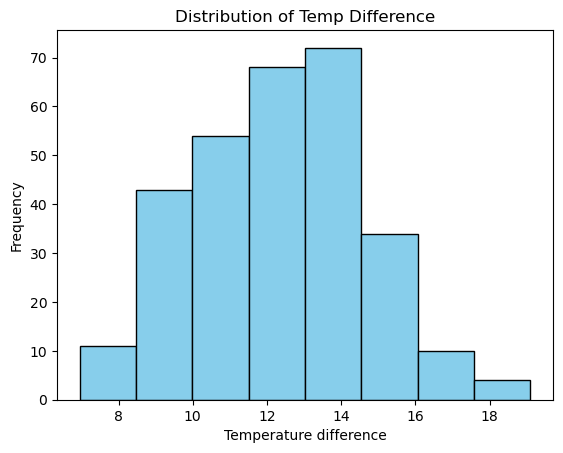

In [587]:
def filling_missed_values(df):
    mask = df['TAVG'].isnull() & (df['TMAX'].notnull() | df['TMIN'].notnull())
    rows_with_missing_tavg = df[mask]
#     print("Rows with missing 'tavg' and present 'tmax' or 'tmin':\n",rows_with_missing_tavg)
    print("\nWe have data for :", rows_with_missing_tavg.shape)
    print("Missing data remaining is :", df['TAVG'].isnull().sum()-rows_with_missing_tavg.shape[0],"rows.\n\n")
    print(df.describe(),"\n")
    if considered_col[0] == 'TMAX':
        df['diff']=df['TMAX']-df['TAVG']
    else:
        df['diff']=df['TAVG']-df['TMIN']
    print("Temperature Difference statistics:\n",df['diff'].describe())
    plt.hist(df['diff'], bins=8, color='skyblue', edgecolor='black')
    plt.xlabel('Temperature difference')
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format('Temp Difference'))
    plt.show()
    return df
df = filling_missed_values(df)

##  9.Function 'filling_value' fills missing values in the 'TAVG' column using linear interpolation based on 'TMAX' and 'TMIN':
- ### If 'TAVG' is missing and 'TMAX' is available, it is filled by subtracting value from above  from 'TMAX'.
- ### If 'TAVG' is missing and 'TMIN' is available, it is filled by adding value from above function to 'TMIN'.
- ### Prints the count of missing values after filling.


In [588]:
def filling_value(df,i):
    df['TAVG'] = df.apply(lambda row: row['TMAX'] - i if pd.isnull(row['TAVG']) and pd.notnull(row['TMAX']) else row['TAVG'], axis=1)
    df['TAVG'] = df.apply(lambda row: row['TMIN'] + i if pd.isnull(row['TAVG']) and pd.notnull(row['TMIN']) else row['TAVG'], axis=1)
    print(df.isnull().sum())
    return df
df = filling_value(df,14)

DATE      0
TAVG    131
TMAX    190
TMIN    160
diff    230
dtype: int64


## 9.Function 'filling_values_from_month' fills missing 'TAVG' values with monthly averages:
- ### Converts 'DATE' column to datetime format and extracts month.
- ### Calculates monthly average 'TAVG'.
- ### Fills missing 'TAVG' values with monthly averages.


In [589]:
def filling_values_from_month(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['MONTH'] = df['DATE'].dt.month
    mask = df['TAVG'].isnull()
    rows_with_missing_tavg = df[mask]
    monthly_avg_tavg = df.groupby('MONTH')['TAVG'].mean().round(2)
    print(monthly_avg_tavg)
    for month, avg_tavg in monthly_avg_tavg.items():
        df.loc[df['MONTH'] == month, 'TAVG'] = df.loc[df['MONTH'] == month, 'TAVG'].fillna(avg_tavg)
    print(df['TAVG'].isnull().sum())
    if 'STATION' in df.columns and 'NAME' in df.columns:
        df = df[['STATION','NAME','DATE','TAVG']]
    else:
        df = df[['DATE','TAVG']]
    return df
df = filling_values_from_month(df)
df.shape

MONTH
1     72.76
2     71.87
3     70.46
4     66.87
5     62.02
6     57.73
7     57.11
8     61.23
9     67.66
10    71.20
11    73.01
12    72.20
Name: TAVG, dtype: float64
0


(526, 2)

In [590]:
df

,DATE,TAVG
0,1974-01-01,70.65
1,1974-02-01,69.95
2,1974-03-01,68.50
3,1974-04-01,63.25
4,1974-05-01,59.70
...,...,...
521,2017-06-01,57.70
522,2017-07-01,57.00
523,2017-08-01,59.80
524,2017-09-01,67.66


## 10.Saving DataFrame to CSV file


In [591]:
df.to_csv("new_data/Swaziland.csv", index=False)